In [1]:
# Navarro, Aaron Christian
# COMP 542 Section # 17019
# Project Model Training and Results 
# Binary Classification for song/music recommendation prediction  
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder  
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, classification_report, confusion_matrix
import time

# root path for all data files 
data_path = "C:/Users/Aaron/Downloads/KKBOXMusicReccommenderSystem"

# target of 1 means that there are recurring listening event(s) trigerred within a month after the user's 
# very first observable listening event. targer of 0 otherwise
full_csv_path = os.path.join(data_path,"train_full_merged_set.csv")

# read all datasets into dataframes
full_merged_set = pd.read_csv(full_csv_path)

# shapes and features of each data set 
print('Shape of train full merged dataset is: ', full_merged_set.shape)

Shape of train full merged dataset is:  (7377418, 37)


In [2]:
full_merged_set.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,isrc_missing,artist_count,first_artist_name,is_featured,member_song_count,artist_song_count,genre_song_count,lang_song_count,song_member_count,age_song_count
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,missing_gender,7,...,0.0,1,Bastille,0,5511,1140,109507,1864413,215,2940499
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,0.0,1,Various Artists,0,622,303506,182072,1864413,1,258688
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,0.0,1,Nas,0,622,289,182072,1864413,4,258688
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,0.0,1,Soundway,0,622,1,39,308497,1,258688
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,missing_gender,7,...,0.0,1,Brett Young,0,5511,427,33568,1864413,412,2940499


In [3]:
full_merged_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 37 columns):
 #   Column              Dtype  
---  ------              -----  
 0   msno                object 
 1   song_id             object 
 2   source_system_tab   object 
 3   source_screen_name  object 
 4   source_type         object 
 5   target              int64  
 6   city                int64  
 7   bd                  int64  
 8   gender              object 
 9   registered_via      int64  
 10  song_length         float64
 11  language            float64
 12  name                object 
 13  membership_days     int64  
 14  registration_year   int64  
 15  registration_month  int64  
 16  registration_day    int64  
 17  expiration_year     int64  
 18  expiration_month    int64  
 19  expiration_day      int64  
 20  first_genre_id      float64
 21  second_genre_id     float64
 22  third_genre_id      float64
 23  genre_ids_count     float64
 24  song_year           obje

In [4]:
full_merged_set.isnull().any()

msno                  False
song_id               False
source_system_tab     False
source_screen_name    False
source_type           False
target                False
city                  False
bd                    False
gender                False
registered_via        False
song_length           False
language              False
name                  False
membership_days       False
registration_year     False
registration_month    False
registration_day      False
expiration_year       False
expiration_month      False
expiration_day        False
first_genre_id        False
second_genre_id       False
third_genre_id        False
genre_ids_count       False
song_year             False
country_code          False
registration_code     False
isrc_missing          False
artist_count          False
first_artist_name      True
is_featured           False
member_song_count     False
artist_song_count     False
genre_song_count      False
lang_song_count       False
song_member_count   

In [5]:
# give a missing value where there is no first_artist_name
full_merged_set['first_artist_name'].fillna('no_artist_name', inplace=True)

In [6]:
# convert language values into string datatype
full_merged_set['language'] = full_merged_set['language'].apply(lambda x: str(x))

In [7]:
# now preprocess data sets
# label encoding for converting categorical features
# standardization to scale numeric features ==> values between (0,1)

all_columns = full_merged_set.columns
numerical_columns = full_merged_set._get_numeric_data().columns
categorical_columns = (set(all_columns) - set(numerical_columns))

print("Categorical Columns")
print(categorical_columns)
print("Numerical Columns")
print(numerical_columns)

Categorical Columns
{'first_artist_name', 'source_type', 'country_code', 'source_system_tab', 'song_year', 'msno', 'source_screen_name', 'language', 'name', 'registration_code', 'song_id', 'gender'}
Numerical Columns
Index(['target', 'city', 'bd', 'registered_via', 'song_length',
       'membership_days', 'registration_year', 'registration_month',
       'registration_day', 'expiration_year', 'expiration_month',
       'expiration_day', 'first_genre_id', 'second_genre_id', 'third_genre_id',
       'genre_ids_count', 'isrc_missing', 'artist_count', 'is_featured',
       'member_song_count', 'artist_song_count', 'genre_song_count',
       'lang_song_count', 'song_member_count', 'age_song_count'],
      dtype='object')


In [8]:
numerical_columns = numerical_columns.delete(0)
print(numerical_columns)

for numeric_feature in numerical_columns:
    scaler = StandardScaler()
    full_merged_set[numeric_feature] = scaler.fit_transform(full_merged_set[numeric_feature].values.reshape(-1,1))

Index(['city', 'bd', 'registered_via', 'song_length', 'membership_days',
       'registration_year', 'registration_month', 'registration_day',
       'expiration_year', 'expiration_month', 'expiration_day',
       'first_genre_id', 'second_genre_id', 'third_genre_id',
       'genre_ids_count', 'isrc_missing', 'artist_count', 'is_featured',
       'member_song_count', 'artist_song_count', 'genre_song_count',
       'lang_song_count', 'song_member_count', 'age_song_count'],
      dtype='object')


In [9]:
encoder = LabelEncoder()
for categoric_feature in categorical_columns:
    full_merged_set[categoric_feature] = encoder.fit_transform(full_merged_set[categoric_feature].astype(str))

In [10]:
full_merged_set.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,isrc_missing,artist_count,first_artist_name,is_featured,member_song_count,artist_song_count,genre_song_count,lang_song_count,song_member_count,age_song_count
0,8158,74679,1,7,6,1,-0.980393,-1.108721,2,0.090489,...,0.0,-0.158441,3038,-0.045345,8.440964,-0.554517,-1.294634,-0.612945,-0.553361,1.227095
1,17259,223479,3,8,4,1,0.826394,0.430229,0,0.969311,...,0.0,-0.158441,30497,-0.045345,-0.050776,3.774785,-1.250797,-0.612945,-0.636409,-0.752320
2,17259,120758,3,8,4,1,0.826394,0.430229,0,0.969311,...,0.0,-0.158441,20364,-0.045345,-0.050776,-0.566702,-1.250797,-0.612945,-0.635245,-0.752320
3,17259,23707,3,8,4,1,0.826394,0.430229,0,0.969311,...,0.0,-0.158441,26165,-0.045345,-0.050776,-0.570825,-1.360764,-1.660930,-0.636409,-0.752320
4,8158,33308,1,7,6,1,-0.980393,-1.108721,2,0.090489,...,0.0,-0.158441,4154,-0.045345,8.440964,-0.564726,-1.340509,-0.612945,-0.476911,1.227095


In [11]:
full_merged_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 37 columns):
 #   Column              Dtype  
---  ------              -----  
 0   msno                int32  
 1   song_id             int32  
 2   source_system_tab   int32  
 3   source_screen_name  int32  
 4   source_type         int32  
 5   target              int64  
 6   city                float64
 7   bd                  float64
 8   gender              int32  
 9   registered_via      float64
 10  song_length         float64
 11  language            int32  
 12  name                int32  
 13  membership_days     float64
 14  registration_year   float64
 15  registration_month  float64
 16  registration_day    float64
 17  expiration_year     float64
 18  expiration_month    float64
 19  expiration_day      float64
 20  first_genre_id      float64
 21  second_genre_id     float64
 22  third_genre_id      float64
 23  genre_ids_count     float64
 24  song_year           int3

In [12]:
# split up the train and test data targets 
# split the training data into a training set and validation set (80-20 split)

X = full_merged_set.drop(['target'], axis=1)
y = full_merged_set['target']

# Train & Test Split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Now split the training set into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=1)


print('Shape of training dataset is: ', X_train.shape)
print('Shape of validation dataset is: ', X_val.shape)
print('Shape of test dataset is: ', X_test.shape)

Shape of training dataset is:  (4721547, 36)
Shape of validation dataset is:  (1180387, 36)
Shape of test dataset is:  (1475484, 36)


In [13]:
# clean up unnecessary data frames 
del full_merged_set
del X_train_full
del y_train_full

In [14]:
# sample our training data for our initial model fiting, really large data sets take large CPU and extended time to fit
# the dataset is too big for our RAM limitations and processing time, need to sample the dataset
import random
random.seed(130)
idx = random.sample(range(0,X_train.shape[0]), 300000)
X_train_sample = X_train.iloc[idx]
y_train_sample = y_train.iloc[idx]

In [15]:
# Initial Model fitting with 100 estimators and all CPUs used 
start_time = time.time()
rf = RandomForestClassifier(n_estimators=100, oob_score=False, random_state=1 ,n_jobs=-1)
rf.fit(X_train_sample, y_train_sample)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [16]:
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))
print("--- %s minutes ---" % ((end_time - start_time)/60))

--- 20.11375880241394 seconds ---
--- 0.33522931337356565 minutes ---


In [17]:
# Initial Model accuracy on validation preditions 
start_time = time.time()
predicted = rf.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score on validation data set: {accuracy:.4}')

Mean accuracy score on validation data set: 0.6709


In [18]:
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))
print("--- %s minutes ---" % ((end_time - start_time)/60))

--- 11.742425441741943 seconds ---
--- 0.19570709069569905 minutes ---


In [19]:
# Initial Model accuracy on test preditions
start_time = time.time()
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean accuracy score on test data set: {accuracy:.4}')

Mean accuracy score on test data set: 0.6708


In [20]:
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))
print("--- %s minutes ---" % ((end_time - start_time)/60))

--- 14.718248844146729 seconds ---
--- 0.24530414740244547 minutes ---


In [21]:
# Analyze model for feature importance and selection
# helper function to generate features and their imporatnce in the RF model
def rf_feat_importance(model, data):
    return pd.DataFrame({'cols':data.columns, 
                         'imp':model.feature_importances_}).sort_values('imp', ascending=False)

feature_importance = rf_feat_importance(rf, X_train_sample); feature_importance[:10]

,cols,imp
34,song_member_count,0.074533
30,member_song_count,0.067532
0,msno,0.059089
12,membership_days,0.056366
1,song_id,0.050265
9,song_length,0.050209
11,name,0.049761
31,artist_song_count,0.047073
15,registration_day,0.046152
18,expiration_day,0.043335


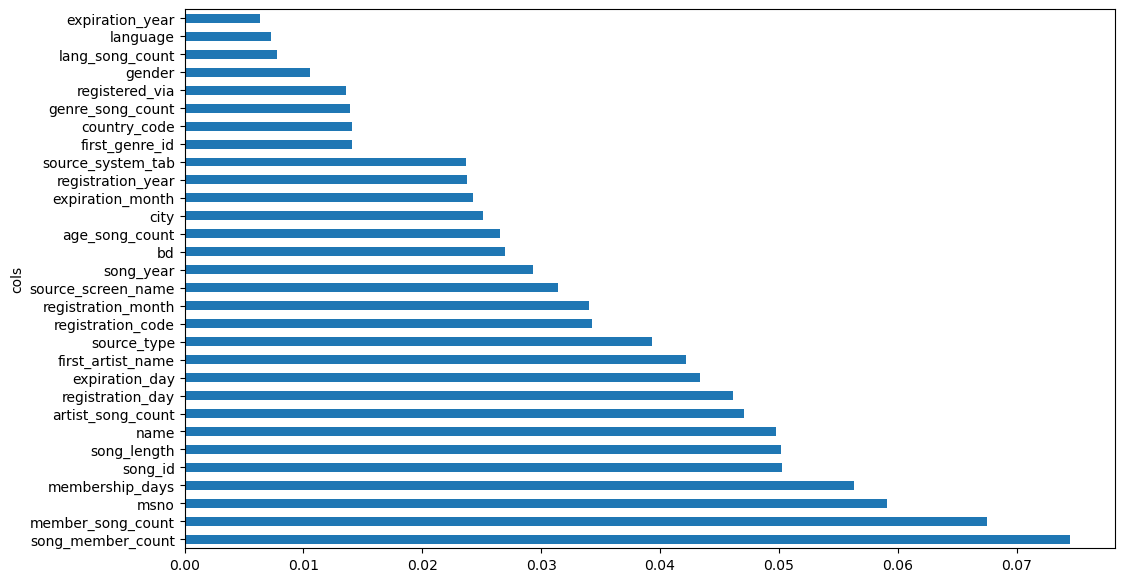

In [22]:
# plot the feature features and their imporatnce in the RF model
# helper function to plot
def plot_feature_importance(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_feature_importance(feature_importance[:30]);

In [23]:
# We can see that 'song_member_count' and 'member_song_count' have the highest importance. 
# They both indiciate when a user repeats speficic song or when a song is repeated by specific users.
# There are several features with less than a 0.015 importance. Removing some of these features will help 
# imporove the impurity of the trees. 

In [24]:
# remove the features wity importance less than 0.015
features_to_keep = feature_importance[feature_importance.imp > 0.015].cols; len(features_to_keep)

22

In [25]:
# we're keeping 22 of the features, dropping the rest
X_train_sample = X_train_sample[features_to_keep]
X_val = X_val[features_to_keep]
X_test = X_test[features_to_keep]
X_train = X_train[features_to_keep]

print('Shape of training sample dataset is: ', X_train_sample.shape)
print('Shape of validation dataset is: ', X_val.shape)
print('Shape of test dataset is: ', X_test.shape)
print('Shape of training dataset is: ', X_train.shape)

Shape of training sample dataset is:  (300000, 22)
Shape of validation dataset is:  (1180387, 22)
Shape of test dataset is:  (1475484, 22)
Shape of training dataset is:  (4721547, 22)


In [27]:
# get rid of the initial Random Forest Model
del rf

In [29]:
# Hyperparameter tuning: we will utilize the Pipeline and GridSearchCV to find the best fitting model
from sklearn.pipeline import Pipeline

start_time = time.time()
pipeline_rf_clf = Pipeline([('clf', RandomForestClassifier(n_jobs=-1))]) 

grid_params = dict(clf__n_estimators = [50,100,150,200],
                  clf__max_features = ['sqrt', 'log2'],
                  clf__min_samples_split = [2,10,20])
# n_estimators: # of trees in the forest  
# max_features: # of features to consider when looking for the best split
# min_samples_split: minimum number of samples required to split an internal node
# criterion: defaulted to "gini", function to measure the quality of a split

gs_model_clf = GridSearchCV(estimator=pipeline_rf_clf,  
                  param_grid=grid_params,
                  scoring='accuracy',
                  verbose=2,
                  cv=5)

gs_model_clf.fit(X_train_sample, y_train_sample)

print('Time taken for hyper parameter tuning is : %s seconds' % (time.time() -  start_time) )
print('Time taken for hyper parameter tuning is : %s minutes' % ((time.time() -  start_time)/60))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=50; total time=   9.1s
[CV] END clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=50; total time=   8.0s
[CV] END clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=50; total time=   8.8s
[CV] END clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=50; total time=   8.4s
[CV] END clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=50; total time=   8.3s
[CV] END clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=100; total time=  15.4s
[CV] END clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=100; total time=  15.2s
[CV] END clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=100; total time=  15.4s
[CV] END clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=100; total time=  16.2s
[CV] END clf__max_features=sqrt, c

[CV] END clf__max_features=log2, clf__min_samples_split=10, clf__n_estimators=50; total time=   8.2s
[CV] END clf__max_features=log2, clf__min_samples_split=10, clf__n_estimators=50; total time=   8.3s
[CV] END clf__max_features=log2, clf__min_samples_split=10, clf__n_estimators=50; total time=   9.2s
[CV] END clf__max_features=log2, clf__min_samples_split=10, clf__n_estimators=50; total time=   9.1s
[CV] END clf__max_features=log2, clf__min_samples_split=10, clf__n_estimators=100; total time=  15.9s
[CV] END clf__max_features=log2, clf__min_samples_split=10, clf__n_estimators=100; total time=  15.8s
[CV] END clf__max_features=log2, clf__min_samples_split=10, clf__n_estimators=100; total time=  16.0s
[CV] END clf__max_features=log2, clf__min_samples_split=10, clf__n_estimators=100; total time=  15.9s
[CV] END clf__max_features=log2, clf__min_samples_split=10, clf__n_estimators=100; total time=  15.9s
[CV] END clf__max_features=log2, clf__min_samples_split=10, clf__n_estimators=150; tot

In [30]:
# show the best estimator out of all the cross validation model fits
print(gs_model_clf.best_estimator_)

Pipeline(steps=[('clf',
                 RandomForestClassifier(max_features='log2', n_estimators=200,
                                        n_jobs=-1))])


In [31]:
# show all specific parameters for the model
gs_model_clf.best_estimator_.get_params()['clf']

RandomForestClassifier(max_features='log2', n_estimators=200, n_jobs=-1)

In [32]:
print('Train data set Accuracy Score = ', gs_model_clf.score(X_train, y_train))
print('Talidation data set Accuracy Score = ', gs_model_clf.score(X_val, y_val))

Train data set Accuracy Score =  0.6939954214159045
Talidation data set Accuracy Score =  0.673056378967237


In [33]:
# delete the hyper paramter tuning Pipeline and GridSeachCV to save memory for next RandomForestClassifier
del gs_model_clf
del pipeline_rf_clf

In [34]:
# build and train the model from the best estimator cross validation
# all hyper-parameters not listed are default values
rf_model = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_features='log2')

start_time = time.time()

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', n_estimators=200, n_jobs=-1)

In [35]:
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))
print("--- %s minutes ---" % ((end_time - start_time)/60))

--- 1345.163304567337 seconds ---
--- 22.419388409455618 minutes ---


In [36]:
# predict after model has been trained on validation data and get accuracy
start_time = time.time()

predicted = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))
print("--- %s minutes ---" % ((end_time - start_time)/60))
print(f'Mean accuracy score validation data: {accuracy:.4}')

--- 56.815898180007935 seconds ---
--- 0.9469316363334656 minutes ---
Mean accuracy score validation data: 0.7425


In [37]:
# predict after model has been trained on test data and get accuracy
start_time = time.time()

predicted = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))
print("--- %s minutes ---" % ((end_time - start_time)/60))
print(f'Mean accuracy score validation data: {accuracy:.4}')

--- 87.51936292648315 seconds ---
--- 1.4586560487747193 minutes ---
Mean accuracy score validation data: 0.7428


In [38]:
# we have a very good increase to 74.3% accuracy on our test data
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.75      0.73      0.74    732119
           1       0.74      0.76      0.75    743365

    accuracy                           0.74   1475484
   macro avg       0.74      0.74      0.74   1475484
weighted avg       0.74      0.74      0.74   1475484



Text(0.5, 1.0, 'Random Forest Classifier Confusion Matrix, Test Data Predicted')

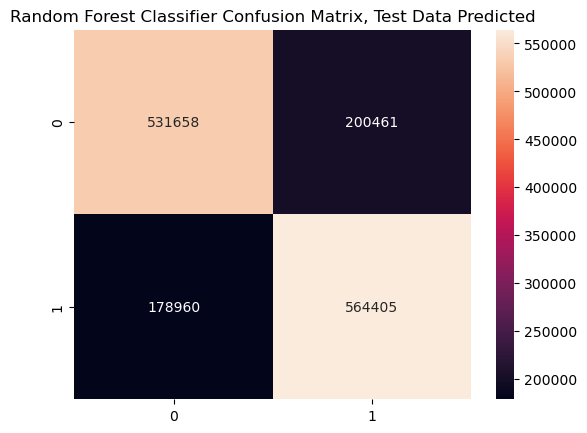

In [39]:
# print a heatmap of the confusion matrix
conf_matr = confusion_matrix(y_test, predicted)
sns.heatmap(conf_matr, annot=True,fmt='d').set_title('Random Forest Classifier Confusion Matrix, Test Data Predicted')

In [40]:
# Predict probability for ROC curve
start_time = time.time()

predicted = rf_model.predict_proba(X_test)
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))
print("--- %s minutes ---" % ((end_time - start_time)/60))

--- 65.83007168769836 seconds ---
--- 1.0971678614616394 minutes ---


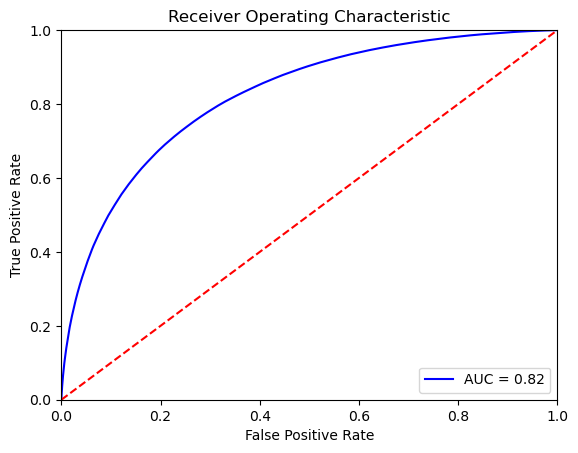

In [41]:
# plot the ROC curve for our test data and predited values
false_positive_rate, true_positive_rate, thresholds = roc_curve(
    y_test, [i[1] for i in predicted])
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 
         'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()